In [1]:
# train_on_csv.py
import os
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import torch

# Base pretrained model
MODEL_NAME = "distilbert-base-uncased"

# Labels for 3-class sentiment classification
LABELS = ["negative", "neutral", "positive"]
ID2LABEL = {i: l for i, l in enumerate(LABELS)}
LABEL2ID = {l: i for i, l in enumerate(LABELS)}

@dataclass
class DS(torch.utils.data.Dataset):
    encodings: Dict
    labels: np.ndarray

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


# def load_data(path: str):
#     """Load a CSV with columns: text,label"""
#     df = pd.read_csv(path)
#     df = df.dropna(subset=["text", "label"]).copy()
#     df["label"] = df["label"].str.lower().str.strip()
#     assert set(df["label"]).issubset(set(LABELS)), f"Labels must be in {LABELS}"
#     return df

def load_data(path: str):
    df = pd.read_csv(path)
    df = df.dropna(subset=["text", "label"]).copy()

    # normalize labels
    df["label"] = df["label"].str.lower().str.strip()

    # keep only desired classes
    df = df[df["label"].isin(["negative", "neutral", "positive"])]

    return df



def main():
    # 1) Load your dataset
    df = load_data("/kaggle/input/twitter-data-labeledpos-neg-neutral/train.csv")

    # 2) Split into train/validation
    train_df, val_df = train_test_split(
        df, test_size=0.1, random_state=42, stratify=df["label"]
    )

    # 3) Tokenizer
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)

    def encode_texts(texts):
        return tok(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=128,
        )

    train_enc = encode_texts(train_df["text"])
    val_enc = encode_texts(val_df["text"])
    y_train = train_df["label"].map(LABEL2ID).values
    y_val = val_df["label"].map(LABEL2ID).values

    # 4) Model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(LABELS),
        id2label=ID2LABEL,
        label2id=LABEL2ID,
    )

    # 5) Training arguments
    # args = TrainingArguments(
    #     output_dir="models/distilbert-sentiment",
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=2e-5,
    #     per_device_train_batch_size=16,
    #     per_device_eval_batch_size=32,
    #     num_train_epochs=3,
    #     weight_decay=0.01,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="eval_loss",
    #     logging_steps=50,
    #     fp16=torch.cuda.is_available(),
    # )
    args = TrainingArguments(
    output_dir="models/distilbert-sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",            # <-- log dir
    logging_strategy="steps",        # <-- log by steps
    logging_steps=50,                # <-- print every 50 steps
    report_to="none",                # <-- turn off wandb
    fp16=torch.cuda.is_available(),
    )

    

    # 6) Datasets
    train_ds = DS(train_enc, y_train)
    val_ds = DS(val_enc, y_val)

    # 7) Metrics
    def compute_metrics(eval_pred):
        from sklearn.metrics import accuracy_score, f1_score

        logits, labels = eval_pred
        preds = logits.argmax(-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro"),
        }

    # 8) Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
    )

    # 9) Train
    trainer.train()

    # 10) Save model + tokenizer
    save_dir = "models/distilbert-sentiment"
    trainer.save_model(save_dir)
    tok.save_pretrained(save_dir)
    print(f"✅ Model and tokenizer saved to {save_dir}")


if __name__ == "__main__":
    main()


2025-08-24 23:20:10.037983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756077610.220490      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756077610.272992      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.506500,0.413977,0.854839,0.851656
2,0.177100,0.249016,0.903226,0.901735
3,0.094800,0.213070,0.928040,0.926013


✅ Model and tokenizer saved to models/distilbert-sentiment


In [2]:
# model_infer.py
from transformers import pipeline
import re
import emoji

_url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
_mention_hashtag_re = re.compile(r"[@#]\w+")
_extra_ws_re = re.compile(r"\s+")

# Load a strong off‑the‑shelf DistilBERT sentiment model
# This is fine‑tuned on SST‑2; great baseline for English social text
_sai = pipeline(
    task="sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    return_all_scores=True,
)

LABEL_MAP = {
    # Map model labels to canonical output (keep consistent with UI)
    "NEGATIVE": "negative",
    "POSITIVE": "positive",
}


def clean_text(text: str) -> str:
    """Light normalization for social posts."""
    if not text:
        return ""
    # demojize (🙂 -> :slightly_smiling_face:), keeps sentiment cues as tokens
    text = emoji.demojize(text, language='en')
    text = _url_re.sub(" ", text)
    text = _mention_hashtag_re.sub(" ", text)
    text = text.replace("&amp;", "and")
    text = _extra_ws_re.sub(" ", text).strip()
    return text


def predict_sentiment(text: str):
    """Return label and probability. Adds a simple neutrality band.

    Neutral heuristic: if max(prob) < 0.60 -> label = neutral
    Adjust this threshold for your dataset.
    """
    cleaned = clean_text(text)
    if not cleaned:
        return {"label": "neutral", "score": 1.0, "raw": []}

    scores = _sai(cleaned)[0]  # list of dicts: {label: POSITIVE/NEGATIVE, score: float}
    # find the top class
    top = max(scores, key=lambda x: x["score"]) if scores else {"label": "POSITIVE", "score": 0.5}
    label = LABEL_MAP.get(top["label"], top["label"]).lower()

    # Neutral band: treat uncertain cases as neutral
    if top["score"] < 0.60:
        label = "neutral"

    return {"label": label, "score": float(top["score"]), "raw": scores, "cleaned": cleaned}


if __name__ == "__main__":
    test = "I didn't love it, but it's not bad either 🙂"
    print(predict_sentiment(test))

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


{'label': 'positive', 'score': 0.9971752166748047, 'raw': [{'label': 'NEGATIVE', 'score': 0.0028248082380741835}, {'label': 'POSITIVE', 'score': 0.9971752166748047}], 'cleaned': "I didn't love it, but it's not bad either :slightly_smiling_face:"}


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:

print(predict_sentiment("Check out this epic streamer!."))


{'label': 'positive', 'score': 0.9996044039726257, 'raw': [{'label': 'NEGATIVE', 'score': 0.00039557329728268087}, {'label': 'POSITIVE', 'score': 0.9996044039726257}], 'cleaned': 'Check out this epic streamer!.'}


In [4]:
import pkg_resources
packages = [
    'transformers', 'torch', 'accelerate', 'scikit-learn', 'pandas', 'numpy',
    'flask', 'waitress', 'jinja2', 'beautifulsoup4', 'emoji', 'regex', 'streamlit'
]
for pkg in packages:
    try:
        version = pkg_resources.get_distribution(pkg).version
        print(f"{pkg}=={version}")
    except pkg_resources.DistributionNotFound:
        print(f"{pkg} not installed")
import sys
print(f"Python=={sys.version}")

transformers==4.52.4
torch==2.6.0+cu124
accelerate==1.8.1
scikit-learn==1.2.2
pandas==2.2.3
numpy==1.26.4
flask==3.1.1
waitress not installed
jinja2==3.1.6
beautifulsoup4==4.13.4
emoji==2.14.1
regex==2024.11.6
streamlit not installed
Python==3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


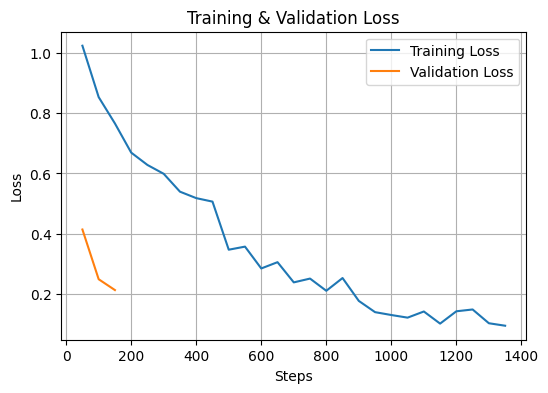

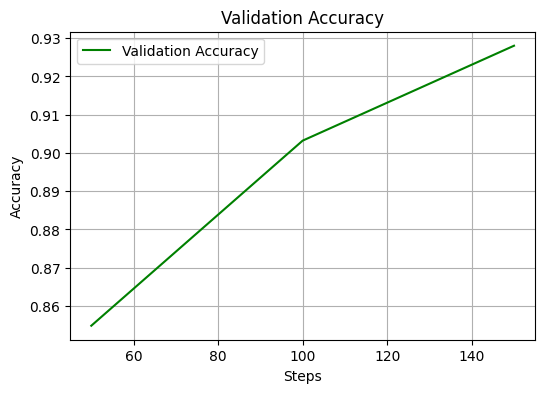

In [5]:
import json
import matplotlib.pyplot as plt

# Path where Trainer saves logs (update if your output_dir is different)
log_file = "/kaggle/working/models/distilbert-sentiment/checkpoint-1362/trainer_state.json"

with open(log_file, "r") as f:
    logs = json.load(f)

train_loss, eval_loss, eval_acc, steps = [], [], [], []

for log in logs["log_history"]:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_acc.append(log["eval_accuracy"])

# --- Loss Curve ---
plt.figure(figsize=(6,4))
plt.plot(steps[:len(train_loss)], train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Accuracy Curve ---
plt.figure(figsize=(6,4))
plt.plot(steps[:len(eval_acc)], eval_acc, label="Validation Accuracy", color="green")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Device set to use cuda:0


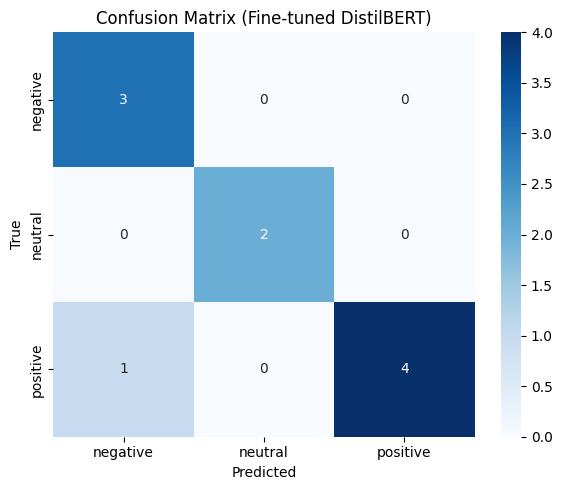


Classification Report:
              precision    recall  f1-score   support

    negative       0.75      1.00      0.86         3
     neutral       1.00      1.00      1.00         2
    positive       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.93      0.92        10
weighted avg       0.93      0.90      0.90        10



In [6]:
# eval_confusion_matrix.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline

# Path to your fine-tuned model (after running train_on_csv.py)
MODEL_DIR = "models/distilbert-sentiment"

# Load dataset (must have columns: text,label)
df = pd.read_csv("/kaggle/input/twitter-data-labeledpos-neg-neutral/test.csv")   # 👈 change path if needed
df = df.dropna(subset=["text", "label"]).copy()
df["label"] = df["label"].str.lower().str.strip()

# Define label order (must match your training)
labels = ["negative", "neutral", "positive"]

# Load fine-tuned model pipeline
clf = pipeline("text-classification", model=MODEL_DIR, tokenizer=MODEL_DIR)

# Run predictions
y_true = df["label"].tolist()
y_pred = [clf(t, truncation=True, padding=True, max_length=128)[0]["label"].lower()
          for t in df["text"].tolist()]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Fine-tuned DistilBERT)")
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels))

